# Fit stochastic SIR models to synthetic data

Starsim can be configured to run as a stochastic SIR model and the model input parameters tuned to fit synthetic data. Doing this is a simple illustration of the process of model calibration. In this exercise, we know what the "true" values are because we create them as part of the exercise. In a more realistic calibration process, both the observed data and the model output will have some amount of error that must be accounted for, so the process will be more complex. For a more realistic Starsim calibration example, see [Calibration](workflows_calibration.ipynb).

[TODO]: <> (Add link to ModelingHub deterministic example once the URL is live.)

The following notebook includes the following two examples:

1. [Agent-based SIR using Optuna](#ex1): Calibrate a stochastic agent-based SIR model implemented using Starsim to data.
2. [Agent-based SIR using Starsim-Optuna integration](#ex2): Use the Calibration class built into the Starsim framework to calibrate a stochastic agent-based SIR model implemented using Starsim to data.

In [ ]:
# Configure notebook autoreloading and inline plotting
%load_ext autoreload
%autoreload 2
%matplotlib inline

##%% Imports and settings
import optuna
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
import starsim as ss
import numpy as np
import pandas as pd
import sciris as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import display

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=optuna.exceptions.ExperimentalWarning)

### Stochastic SIR using Optuna outside of Starsim
<a id="ex1"></a>

First, we create a simple agent-based SIR simulation using Starsim.

In [ ]:
def make_sim():
    """
    Make a simple SIR simulation using Starsim.

    Returns
    -------
    Sim
        A single simulation that has been configured, but not initialized or run.
    """
    sir_pars = dict(
        init_prev = 0.01,
        p_death = 0,
    )
    sir = ss.SIR(pars=sir_pars)

    net = ss.MixingPool(
        beta = 1, # This is a multiplier on the disease beta
        contacts = 1,
    )

    sim_pars = dict(
        n_agents = 1000,
        unit = 'days',
        dt = 1,
        start = '2025-01-01',
        dur = 100,
        verbose = 0,
    )
    sim = ss.Sim(pars=sim_pars, diseases=sir, networks=net)
    return sim

def modify_sim(sim, calib_pars, rand_seed=0):
    """
    Modify the given simulation with the calibration parameters and random seed.
    
    Parameters
    ----------
    sim : Sim
        The simulation to modify.
    calib_pars : dict
        The calibration parameters to apply; note that the parameter values to use are stored in "value."
    rand_seed : int
        The random seed to use for the simulation.

    Returns
    -------
    Sim
        The modified simulation.
    """

    # Explicitly look for each of the calibration parameters and set the appropriate values
    if 'beta' in calib_pars:
        β = ss.rate_prob(calib_pars['beta']['value'], unit='days')
        sim.pars.diseases.pars['beta'] = β

    if 'gamma' in calib_pars:
        γ = calib_pars['gamma']['value']
        sim.pars.diseases.pars['dur_inf'].set(1/γ)

    sim.pars['rand_seed'] = rand_seed

    return sim


def run_starsim(pars, rand_seed=0):
    """
    Run a Starsim SIR model with given parameters and random seed, returning results.
    
    Parameters
    ----------
    pars : dict
        The parameters dictionary with Optuna a values stored in "value."
    rand_seed : int
        The random seed to use for the simulation.

    Returns
    -------
    dataframe
        The results of the SIR model with columns of S, I, and R and index of Time.
    """
    # Make and modify the simulation
    sim = make_sim()
    sim = modify_sim(sim, pars, rand_seed)

    sim.run() # Run the simulation

    # Extract the results
    results = pd.DataFrame(dict(
        S = sim.results.sir.n_susceptible,
        I = sim.results.sir.n_infected,
        R = sim.results.sir.n_recovered,
    ), index=pd.Index(sim.results.timevec, name='Time'))
    results['rand_seed'] = rand_seed # Store the random seed for later reference

    return results

That sets of the basic machinery of the model. Next, we'll next create some synthetic data to use as calibration targets. Because the model is stochastic, we'll average over several replicates.

Here is the data extracted from the average simulation to be used during calibration:



,x,n,Prevalence
t,,,
2025-01-21,83,1000.0,0.0830
2025-02-10,317,1000.0,0.3174
2025-03-22,165,1000.0,0.1655


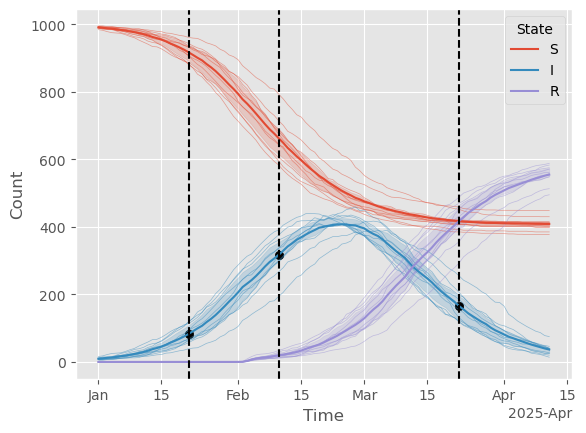

In [ ]:
n_reps = 10 # Number of repetitions to run

# These are the true parameters the optimizer will later try to identify
true_pars = dict(
    beta = dict(value=0.12),
    gamma = dict(value=0.03),
)

# Run the starsim SIR simulations in parallel. If you need to run in serial, for example when debugging, simply set serial=True
results_list = sc.parallelize(run_starsim, pars=true_pars, iterkwargs=dict(rand_seed=np.arange(n_reps)), serial=False)
results = pd.concat(results_list) # Combine the results into a single DataFrame
ave = results.groupby('Time').mean().drop(columns='rand_seed') # Average the results over the repetitions

# Extract synthetic data for calibration
observation_times = np.array([pd.Timestamp('2025-01-01')+pd.DateOffset(days=d) for d in [20, 40, 80]])
starsim_data = pd.DataFrame({
    'x': ave.loc[observation_times, 'I'].astype(int),
    'n': ave.loc[observation_times].sum(axis=1),
    'Prevalence': ave.loc[observation_times, 'I'] / ave.loc[observation_times].sum(axis=1)
}, index=pd.Index(observation_times, name='t'))

print('Here is the data extracted from the average simulation to be used during calibration:\n')
display(starsim_data)

# Plot the results, vertical dashed lines indicate the observation times where prevalence is measured
df = results.reset_index().melt(id_vars=['Time', 'rand_seed'], value_vars=['S', 'I', 'R'], var_name='State', value_name='Count')
ax = sns.lineplot(data=df, hue='State', x='Time', y='Count', units='rand_seed', estimator=None, alpha=0.5, lw=0.5, legend=False)
sns.lineplot(data=df, hue='State', x='Time', y='Count', errorbar=('pi', 50), ax=ax, legend=True)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
for ot in observation_times:
    ax.axvline(ot, ls='--', color='black')
ax.scatter(starsim_data.index, starsim_data['x'], marker='o', color='black', label='Observed data')

Now we'll set about trying to calibrate to this data using Optuna.

The best parameters identified by the optimization are:
    * {'beta': 0.11541841716588146, 'gamma': 0.030213887236523466}
    These parameters should be close to the true parameters:
    * {'beta': {'value': 0.12}, 'gamma': {'value': 0.03}}
    The best parameters resulted in a loss of 5.6009999999999445e-05.


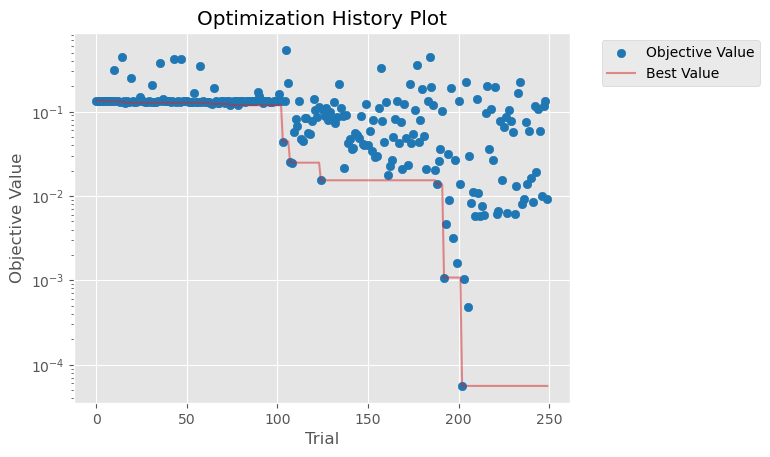

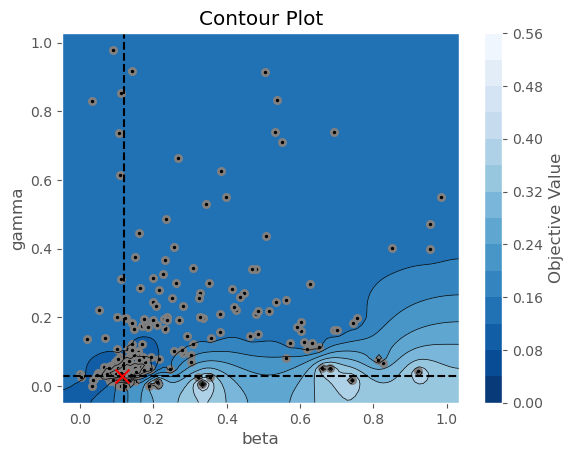

In [ ]:
def objective(trial):
    """
    Evaluate a trial by running the Starsim model and comparing the results to the calibration data.

    Parameters
    ----------
    trial: optuna.Trial
        The trial to map.

    Returns
    -------
    float
        The objective value of the trial
    """
    pars = trial_to_pars(trial)
    result = run_starsim(pars, rand_seed=0)
    objective = evaluate(result[['S', 'I', 'R']], starsim_data[['Prevalence']])
    return objective

# The following two lines create an Optuna study and optimize the objective function - easy!
study = optuna.create_study()
study.optimize(objective, n_trials=250) # We'll run 250 total trials. This may take a few minutes, depending on your computer. Consider reducing this number if you like.

# Print a summary
sc.colorize(color='blue', string=f'The best parameters identified by the optimization are:\n\
    * {study.best_params}\n\
    These parameters should be close to the true parameters:\n\
    * {true_pars}\n\
    The best parameters resulted in a loss of {study.best_value}.')

# Plot the results
fig = optuna.visualization.matplotlib.plot_optimization_history(study);
fig.axes.set_yscale('log')

ax = optuna.visualization.matplotlib.plot_contour(study);
ax.axvline(true_pars['beta']['value'], ls='--', color='black')
ax.axhline(true_pars['gamma']['value'], ls='--', color='black')
ax.scatter(study.best_params['beta'], study.best_params['gamma'], 100, marker='x', color='red', zorder=10);

The parameters seem pretty good! Let's see what simulation look like using the best parameters.

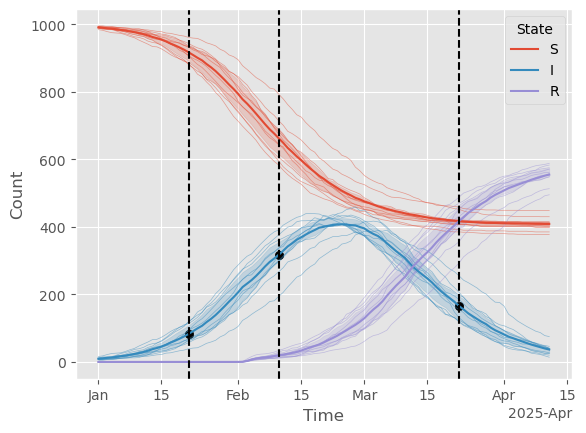

In [ ]:
n_reps = 10 # Number of repetitions to run

# These are the true parameters the optimizer will later try to identify.
best_pars = dict(
    beta = dict(value=study.best_params['beta']),
    gamma = dict(value=study.best_params['gamma']),
)

# Run the starsim SIR simulations in parallel. If you need to run in serial, for example when debugging, simply set serial=True
results_list = sc.parallelize(run_starsim, pars=true_pars, iterkwargs=dict(rand_seed=np.arange(n_reps)), serial=False)
results = pd.concat(results_list) # Combine the results into a single DataFrame

# Plot the results, vertical dashed lines indicate the observation times where prevalence is measured
df = results.reset_index().melt(id_vars=['Time', 'rand_seed'], value_vars=['S', 'I', 'R'], var_name='State', value_name='Count')
ax = sns.lineplot(data=df, hue='State', x='Time', y='Count', units='rand_seed', estimator=None, alpha=0.5, lw=0.5, legend=False)
sns.lineplot(data=df, hue='State', x='Time', y='Count', errorbar=('pi', 50), ax=ax, legend=True)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
for ot in observation_times:
    ax.axvline(ot, ls='--', color='black')
ax.scatter(starsim_data.index, starsim_data['x'], marker='o', color='black', label='Observed data')

The fit looks great! Onto the next example.

### Stochastic SIR using Optuna integrated within Starsim
<a id="ex2"></a>

The previous example used the Optuna Bayesian optimization algorithm as a "wrapper" around a stochastic disease model. Starsim provides built-in integration with Optuna to make advanced model calibration easier. We demonstrate that linkage below.

In this example, we use a Beta-binomial likelihood function; however, results shouldn't be too different from the simple example above that used a squared error metric.

In [10]:
sim = make_sim() # Begin by making a single "base" simulation with default parameters

# This example will use a single calibration component
# We choose a Beta-binomial functional form to represent the "prevalence survey" data, taking advantage of both the numerator (x) and denominator (n) data.
prevalence_component = ss.BetaBinomial(
    name = 'SIR Disease Prevalence',
    conform = 'step_containing', # The starsim_data data has a date for each observation. The "step_containing" conform method will extract simulation results on the time step containing the observation date.

    # Here is the data we are trying to match, using the "x" and "n" columns from the starsim_data DataFrame.
    expected = starsim_data[['x', 'n']],

    # And here is how we will extract the relevant data from the simulation results
    extract_fn = lambda sim: pd.DataFrame({
        'x': sim.results.sir.n_infected, # Numerator
        'n': sim.results.n_alive, # Denominator
    }, index=pd.Index(sim.results.timevec, name='t')),
)

# Make the calibration
calib = ss.Calibration(
    sim = sim,                              # The base simulation
    calib_pars = calib_pars,                # The calibration parameters
    build_fn = modify_sim,                  # The function to modify the base simulation with the calibration parameters
    reseed = False,                         # In this example, we will not reseed the simulation for each calibration trial
    components = [prevalence_component],    # The calibration components
    total_trials = 250,                     # We will run 250 total trials, as before. This might take some time, depending on your computer.
    verbose = False,                        # Shh...
)

calib.calibrate() # Let's go!

# Print out a summary
sc.colorize(color='blue', string=f'The best parameters identified by the optimization are:\n\
    * {calib.best_pars}\n\
    These parameters should be close to the true parameters:\n\
    * {true_pars}\n\
    The best parameters resulted in a loss of {calib.study.best_value}.')

The best parameters identified by the optimization are:
    * {'beta': 0.11674186025831722, 'gamma': 0.02940171022822831}
    These parameters should be close to the true parameters:
    * {'beta': {'value': 0.12}, 'gamma': {'value': 0.03}}
    The best parameters resulted in a loss of 3.7771526958267336.


It seems like the best parameter values are pretty close to the right values, so that's good. We can look at all the results and easily create a DataFrame containing the top K runs.

In [11]:
df = calib.to_df(top_k=10)
display(df)

,value,datetime_start,datetime_complete,duration,params_beta,params_gamma,state
number,,,,,,,
237,3.777153,2025-02-21 16:52:56.316179,2025-02-21 16:52:56.425351,0 days 00:00:00.109172,0.116742,0.029402,COMPLETE
205,4.526405,2025-02-21 16:52:55.662512,2025-02-21 16:52:55.836964,0 days 00:00:00.174452,0.125890,0.028847,COMPLETE
222,4.897333,2025-02-21 16:52:55.986572,2025-02-21 16:52:56.132334,0 days 00:00:00.145762,0.114437,0.032779,COMPLETE
202,5.023078,2025-02-21 16:52:55.675326,2025-02-21 16:52:55.883810,0 days 00:00:00.208484,0.131341,0.028239,COMPLETE
244,5.116152,2025-02-21 16:52:56.520678,2025-02-21 16:52:56.633975,0 days 00:00:00.113297,0.111385,0.028485,COMPLETE
236,5.638444,2025-02-21 16:52:56.301513,2025-02-21 16:52:56.411882,0 days 00:00:00.110369,0.115534,0.034137,COMPLETE
240,5.948643,2025-02-21 16:52:56.387818,2025-02-21 16:52:56.514539,0 days 00:00:00.126721,0.118464,0.034021,COMPLETE
238,6.225099,2025-02-21 16:52:56.349466,2025-02-21 16:52:56.459961,0 days 00:00:00.110495,0.113925,0.034394,COMPLETE
206,7.663725,2025-02-21 16:52:55.717556,2025-02-21 16:52:55.831315,0 days 00:00:00.113759,0.126698,0.025803,COMPLETE


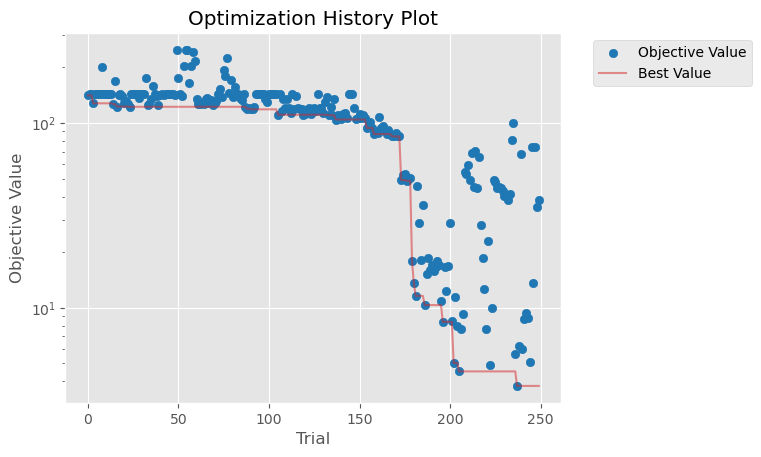

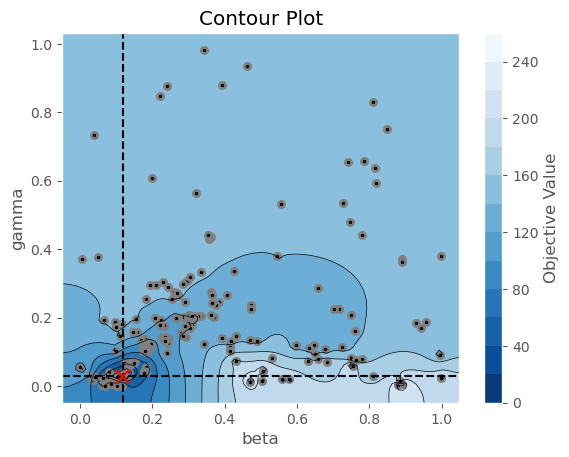

In [12]:
# Plot the results
figs = calib.plot_optuna(['plot_optimization_history', 'plot_contour']);
figs[0].axes.set_yscale('log')

figs[1].axvline(true_pars['beta']['value'], ls='--', color='black');
figs[1].axhline(true_pars['gamma']['value'], ls='--', color='black');
figs[1].scatter(calib.study.best_params['beta'], calib.study.best_params['gamma'], 100, marker='x', color='red', zorder=10);

Finally, let's run some simulations with the best parameters and compare to the calibration data.

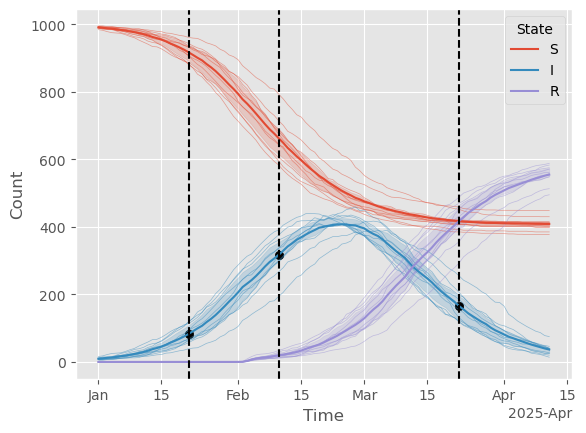

In [13]:
n_reps = 10 # Number of repetitions to run

# These are the true parameters! Shhh, don't tell the optimizer.
best_pars = dict(
    beta = dict(value=calib.study.best_params['beta']),
    gamma = dict(value=calib.study.best_params['gamma']),
)

# Run the starsim SIR simulations in parallel, cool! If you need to run in serial, for example when debugging, simply set serial=True
results_list = sc.parallelize(run_starsim, pars=true_pars, iterkwargs=dict(rand_seed=np.arange(n_reps)), serial=False)
results = pd.concat(results_list) # Combine the results into a single DataFrame

# Plot the results, vertical dashed lines indicate the observation times where prevalence is measured
df = results.reset_index().melt(id_vars=['Time', 'rand_seed'], value_vars=['S', 'I', 'R'], var_name='State', value_name='Count')
ax = sns.lineplot(data=df, hue='State', x='Time', y='Count', units='rand_seed', estimator=None, alpha=0.5, lw=0.5, legend=False)
sns.lineplot(data=df, hue='State', x='Time', y='Count', errorbar=('pi', 50), ax=ax, legend=True)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
for ot in observation_times:
    ax.axvline(ot, ls='--', color='black')
ax.scatter(starsim_data.index, starsim_data['x'], marker='o', color='black', label='Observed data');

These results also look great.